In [1]:
import numpy as np
import pandas as pd

from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.neuralforecast import NeuralForecastRNN, NeuralForecastLSTM
from sktime.split import temporal_train_test_split
from sktime.utils.plotting import plot_series

import pandas_datareader.data as web

# настройки визуализации
import matplotlib.pyplot as plt

# Не показывать Warnings
import warnings
warnings.simplefilter(action='ignore', category=Warning)
# Не показывать ValueWarning, ConvergenceWarning из statsmodels
from statsmodels.tools.sm_exceptions import ValueWarning, ConvergenceWarning
warnings.simplefilter('ignore', category=ValueWarning)
warnings.simplefilter('ignore', category=ConvergenceWarning)

In [2]:
m2 = web.DataReader(name='WM2NS', data_source='fred', start='1995-01-01')
y = np.log(m2).diff().dropna()*100 #умножаем ради увеличения масштаба, лучше обучается модель

<Axes: xlabel='DATE'>

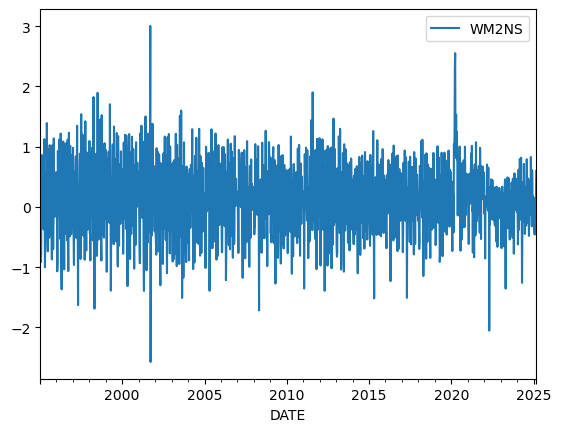

In [3]:
y.plot()

In [4]:
forecaster = AutoARIMA(information_criterion='bic', test='kpss', seasonal=False)
forecaster.fit(y)
forecaster.get_fitted_params() #['order']

{'intercept': 0.16517688124968985,
 'ar.L1': 0.3008026018482898,
 'ar.L2': -0.6789723194134915,
 'ar.L3': -0.2729224523719348,
 'ar.L4': 0.38872950939006534,
 'ar.L5': -0.2391096180100209,
 'ma.L1': -0.2794177808051037,
 'ma.L2': 0.9690256248145883,
 'sigma2': 0.15580535469911924,
 'order': (5, 0, 2),
 'seasonal_order': (0, 0, 0, 0),
 'aic': 1570.3558263212992,
 'aicc': 1570.4709158353658,
 'bic': 1618.6082051820954,
 'hqic': 1588.2882686172275}

In [5]:
y_train, y_test = temporal_train_test_split(y, test_size=20)

In [6]:
forecaster = ARIMA(order=(5,0,2), trend='ct')
y_pred_arima = forecaster.fit_predict(y_train, fh=y_test.index)

In [7]:
model_rnn = NeuralForecastRNN("W-Mon", max_steps=10)

y_pred_rnn = model_rnn.fit_predict(y_train, fh=y_test.index)

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | RNN           | 121 K  | train
4 | context_adapter | Linear        | 40.2 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
163 K     Trainable params
0         Non-trainable params
163 K     Total params
0.654     Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

In [8]:
model_lstm = NeuralForecastLSTM("W-Mon", max_steps=10)

y_pred_lstm = model_lstm.fit_predict(y_train, fh=y_test.index)

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 484 K  | train
4 | context_adapter | Linear        | 40.2 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
526 K     Trainable params
0         Non-trainable params
526 K     Total params
2.106     Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

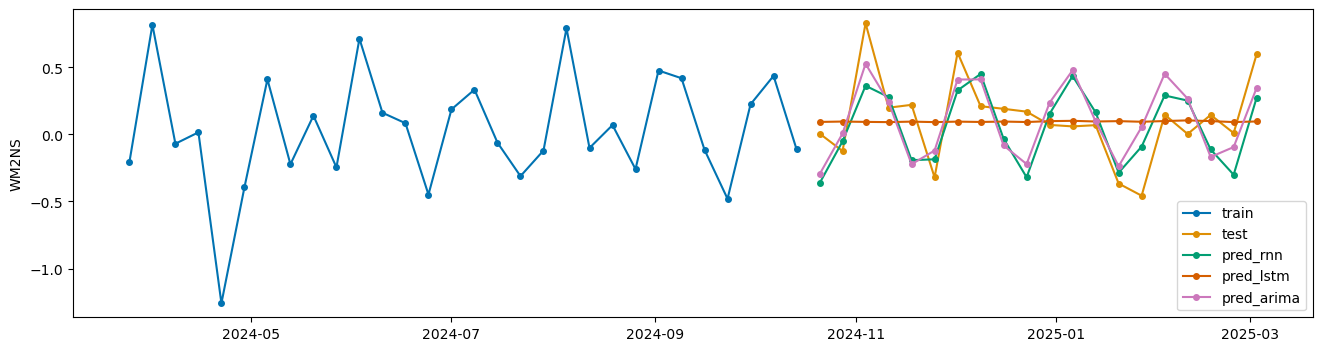

In [9]:
plot_series(y_train.tail(30), y_test, y_pred_rnn, y_pred_lstm, y_pred_arima, labels=['train', 'test', 'pred_rnn', 'pred_lstm', 'pred_arima'])

plt.show()

In [10]:
from sktime.performance_metrics.forecasting import MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError # Метрики MSE, MAE, MAPE

In [11]:
metric = MeanSquaredError(square_root=False)

metric.evaluate(y_test, y_pred_arima), metric.evaluate(y_test, y_pred_rnn), metric.evaluate(y_test, y_pred_lstm)

(0.0781580393487025, 0.08152919337464773, 0.09426807795567907)

In [12]:
metric = MeanAbsoluteError()

metric.evaluate(y_test, y_pred_arima), metric.evaluate(y_test, y_pred_rnn), metric.evaluate(y_test, y_pred_lstm)

(0.24886631899060346, 0.25295384172931995, 0.21925456507934804)

In [13]:
metric = MeanAbsolutePercentageError()

metric.evaluate(y_test, y_pred_arima), metric.evaluate(y_test, y_pred_rnn), metric.evaluate(y_test, y_pred_lstm)

(8.136106125525737, 9.313906800115316, 3.2665840775399877)